<a href="https://colab.research.google.com/github/BirenderPanwar/tsai_eva4p2/blob/master/5-HumanPoseEstimation/notebooks/S5_HPE_OnnxRuntime_Inferencing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Baseline for Human Pose Estimation and Tracking
## Inferencing of HPE Resnet50 model using Onnxruntine

1. Pytorch Resnet50 model trained in MPII dataset is used.
2. Model is converted into ONNX format
3. ONNX model is quantized to reduce the model file size from 130MB to around 65MB
4. ONNX Runtine is used for inferencing the model
5. As target is to deploy the model into AWS Lambda, so no pytorch packages is used here. PIL and Numpy function is used to resizing the image and normalization.
6. Package dependency: numpy, PIL, OpenCV, onnxruntine
7. With above apporach, package size for AWS lambda is around 110MB and its well within the limit required for deployment.


### Reference Materials:
1. https://github.com/Microsoft/human-pose-estimation.pytorch
2. Paper: https://arxiv.org/pdf/1804.06208.pdf
3. Model is downloaded from: https://onedrive.live.com/?authkey=%21AFkTgCsr3CT9%2D%5FA&id=56B9F9C97F261712%2110709&cid=56B9F9C97F261712



In [1]:
# mount gdrive
mount_drive = True
if mount_drive:
    from google.colab import drive
    drive.mount('/content/gdrive') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
os.chdir('/content/gdrive/My Drive/TSAI/EVA4_Phase2/session5/notebooks/')
print(os.getcwd())

/content/gdrive/My Drive/TSAI/EVA4_Phase2/session5/notebooks


In [3]:
# Import standard packages
import PIL
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
from utils.hpe_vis_utils import vis_joints, vis_all_joints, vis_skeleton
from utils.hpe_skeleton_utils import get_skeleton
from utils.hpe_transform_utils import transform_image

In [5]:
# To autoreload all te custom files when modified
import autoreload
%load_ext autoreload
%autoreload

In [6]:
from pathlib import Path
RESULT_DIR = f'./results'
Path(RESULT_DIR).mkdir(exist_ok=True)

# Importing ONNX model and using onnxruntine for inferencing

In [7]:
!pip install onnxruntime

In [8]:
import onnxruntime    # Using ONNX Runtime for inferencing onnx format model

HPE_QNNX_MODEL_PATH = f'./hpe_trained_model/pose_resnet_50_256x256_quantized.onnx'

ort_s = onnxruntime.InferenceSession(HPE_QNNX_MODEL_PATH)

In [9]:
TEST_IMG_FILE = './test_images/img1.jpg'
inp_img = Image.open(TEST_IMG_FILE)

In [10]:
# HPE Pose Prediction using ONNX Runtime
def get_poses_predictions(ort_s, img):
    tr_img = transform_image(img)
    inp = {ort_s.get_inputs()[0].name: tr_img}
    out = ort_s.run(None, inp)
    out = np.array(out[0][0])
    return out

In [11]:
# HPE Pose Prediction using ONNX Runtime
output = get_poses_predictions(ort_s=ort_s, img=inp_img)
print(f'Number of Joints: {output.shape[0]}, Heatmap Size: {output[0].shape}')

Number of Joints: 16, Heatmap Size: (64, 64)


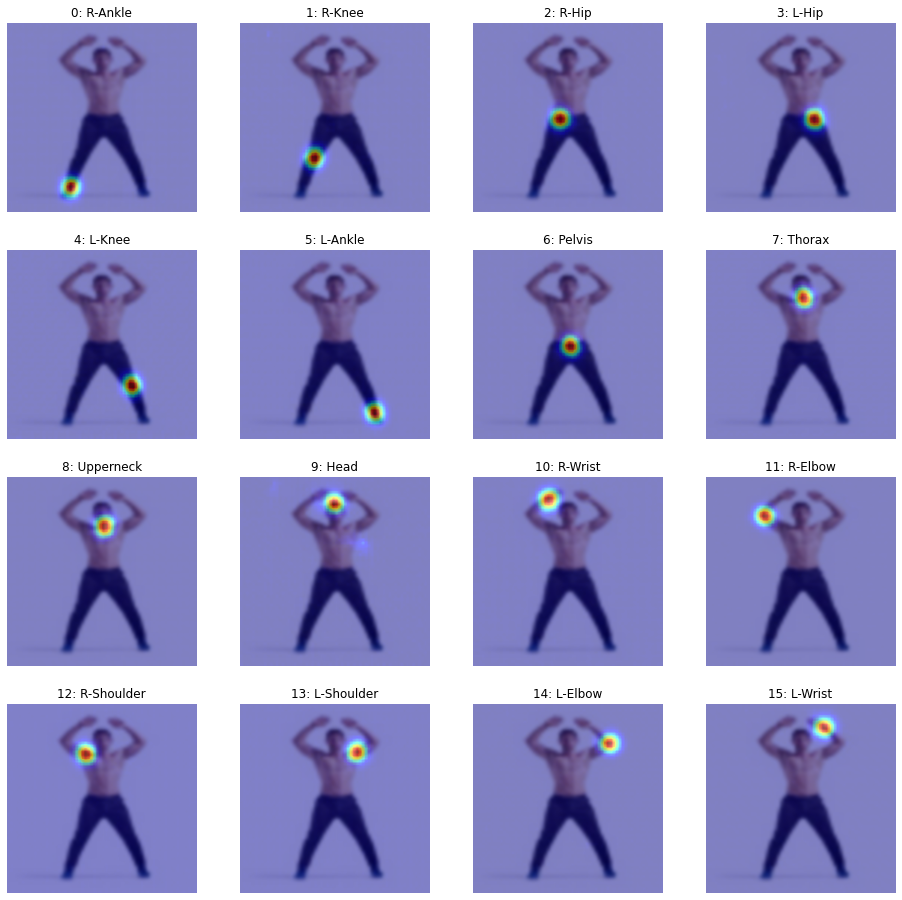

In [12]:
# Visualize each of the joint images
vis_joints(inp_img, output, save_filename=f'./results/joint_onnx.jpg')

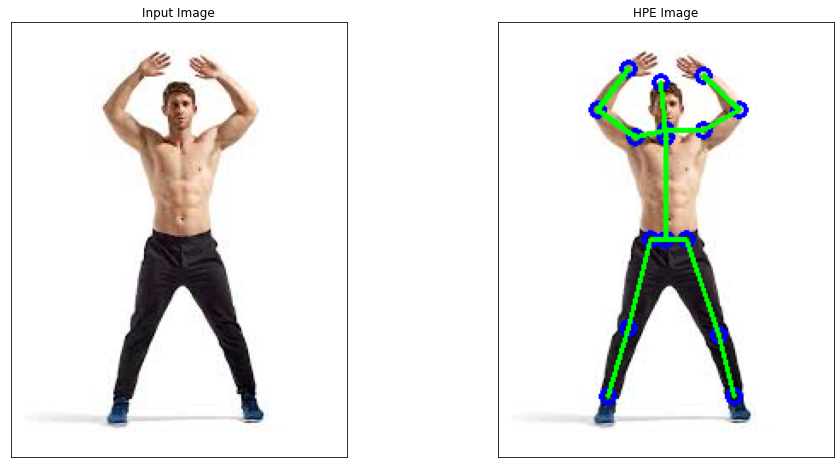

In [13]:
# Connect all joints and then visualize together
vis_skeleton(inp_img, output, save_filename=f'./results/skeleton_onnx.jpg')

## Converting image to Base64 for transferring over the Network for Rendering on HTML

In [14]:
from PIL import Image
import io
import base64

def img_to_base64(img):
    img = Image.fromarray(img, 'RGB') 
    buffer = io.BytesIO()
    img.save(buffer,format="JPEG")
    myimage = buffer.getvalue()                     
    img_str = f"data:image/jpeg;base64,{base64.b64encode(myimage).decode()}"
    return img_str

''
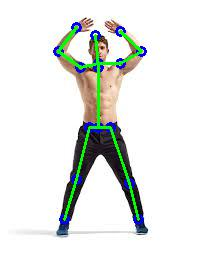

In [15]:
hpe_img = get_skeleton(inp_img, output)
img_str = img_to_base64(hpe_img)
img_str